**TF Intro** [WIP]


Official docs are organized in a really confusing way (or maybe just targeted at an entirely different audience than "software engineers getting started with machine learning"...).

**Getting started tutorials** - very basic use-case examples, no good explanation of core concepts:
- https://www.tensorflow.org/tutorials
- https://www.tensorflow.org/tutorials/quickstart/beginner
- https://www.tensorflow.org/tutorials/quickstart/advanced

Some good (better, I'd say!) 3rd party intro tutorials:
- https://sanjayasubedi.com.np/deeplearning/tensorflow-2-first-neural-network-for-fashion-mnist/
- https://sanjayasubedi.com.np/deeplearning/tensorflow-2-first-neural-network-for-fashion-mnist/
- https://sanjayasubedi.com.np/deeplearning/keras-example-cnn-with-fashion-mnist-dataset/

**Guides** - more advanced examples & some explanations of the core concepts and architecture:
- https://www.tensorflow.org/guide
- https://www.tensorflow.org/guide/effective_tf2 - **might want to start here**
- https://www.tensorflow.org/guide/keras/overview - 
- https://www.tensorflow.org/guide/data - **you MUST understand this!**

**"Customization" part of guides** - depite being thoroughly misnamed (it's not about "costomizaing the framework"or whatever) **THIS is actually where lots of medium-advanced TF concepts are actually explained!**

**Best conceptual dicussion of what and why of TF "eager mode" vs. "graph mode"** - one of the core usability improvements from TF 1 to TF 2 (**read this even if you never used TF 1 before... the TF 2 docs skip on a lot of core graph computation concepts that you'll see used in real world code!**):
- https://github.com/tensorflow/community/blob/master/rfcs/20180918-functions-not-sessions-20.md

**API docs:** https://www.tensorflow.org/api_docs/python/tf

**TWO** high level interfaces:

- **Keras** - the currently preferred higher level interface: https://www.tensorflow.org/guide/keras/overview
  - Keras was originally a multi-backend ML-Deep-Learning frameork (could use as "backend" TF, Theano etc.)
  - current version of Keras was merged into TF (and developemnt of alternative backends support abandoned)
- **Estimators** - this is the "old" high level TF interface - still maintained (apparently bc. it's being used in production inside google), and used as preferred high-level models format by some TF-related infra (and there are tools to convert eg. Keras models into Estimators)
  - https://www.tensorflow.org/tutorials/estimator/premade
  - https://www.tensorflow.org/guide/estimator

# Environment / Imports

In [3]:
import functools

import IPython.display
from IPython.display import display

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras as keras
# import tensorflow_hub as hub

In [2]:
# simple decorator to allow incremental building of classes by adding methods
# in multiple notebooks cells
def add_to_class(klass):
    """
    Usage
    -----
    >>> @add_to_class(MyModel)
    ... def train(self, x, y):
    ...     ...
    """
    def decorator(fn): 
        setattr(klass, fn.__name__, fn)
        return fn
    return decorator

# Data to play with

## Regression data

Auto MPG dataset - we'll predict fuel consumption from other car parameters

In [3]:
# fetch CSV data
regr_dataset_path = keras.utils.get_file(
    "auto-mpg.data",
    "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
regr_dataset_path

# load into a Pandas DataFrame
regr_column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                     'Acceleration', 'Model Year', 'Origin']
regr_raw_dataset = pd.read_csv(
    regr_dataset_path, names=regr_column_names,
    na_values="?", comment='\t',
    sep=" ", skipinitialspace=True)

# take a look at the data
regr_dataset = regr_raw_dataset.copy()
display(regr_dataset.tail())
display(regr_dataset.info())
regr_dataset.describe().T

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MPG           398 non-null    float64
 1   Cylinders     398 non-null    int64  
 2   Displacement  398 non-null    float64
 3   Horsepower    392 non-null    float64
 4   Weight        398 non-null    float64
 5   Acceleration  398 non-null    float64
 6   Model Year    398 non-null    int64  
 7   Origin        398 non-null    int64  
dtypes: float64(5), int64(3)
memory usage: 25.0 KB


None

,count,mean,std,min,25%,50%,75%,max
MPG,398.0,23.514573,7.815984,9.0,17.500,23.0,29.000,46.6
Cylinders,398.0,5.454774,1.701004,3.0,4.000,4.0,8.000,8.0
Displacement,398.0,193.425879,104.269838,68.0,104.250,148.5,262.000,455.0
Horsepower,392.0,104.469388,38.491160,46.0,75.000,93.5,126.000,230.0
Weight,398.0,2970.424623,846.841774,1613.0,2223.750,2803.5,3608.000,5140.0
Acceleration,398.0,15.568090,2.757689,8.0,13.825,15.5,17.175,24.8
Model Year,398.0,76.010050,3.697627,70.0,73.000,76.0,79.000,82.0
Origin,398.0,1.572864,0.802055,1.0,1.000,1.0,2.000,3.0


In [4]:
# since only a few rows have missing data, just drop them
regr_dataset.dropna(inplace=True)
# regr_dataset.info()

In [5]:
regr_y = regr_dataset.pop('MPG')
regr_y.shape, regr_dataset.shape

((392,), (392, 7))

# TF LR from scratch example

This is just to introduce TF 2, has no practical usefulness - eg. you'd solve this with basic (linear) algebra, not with machine-learning and gradient-descent 😀

Inspired by: https://sanjayasubedi.com.np/deeplearning/tensorflow-2-linear-regression-from-scratch/

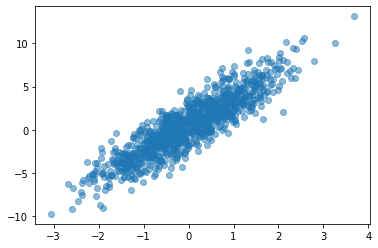

In [6]:
## generate some data
TRUE_W = 3.0
TRUE_B = 0.5
NUM_POINTS = 1000

x = tf.random.normal(shape=(NUM_POINTS,))  # : tf.Tensor (eager)
noise = tf.random.normal((NUM_POINTS,), stddev=1.5)
y = x * TRUE_W + TRUE_B + noise

plt.scatter(x, y, alpha=0.5);

In [7]:
# above "just works" because in eager mode (default for TF 2.0):
# - you can simply get the actual value (and shape, and dtype) of a tensor
#   by just calling `.numpy()` method
# - accessing tensors by index and casting to basic Python & Numpy types
#   also "just works" in eager mode
# - hence, for most practical purposes, `tf.Tensor` values behave as Numpy
#   array and can be used wherever such arrays are expected (like in
#   pyplot functions)
type(x), tuple(x.shape), x.dtype, float(x[0]), x[0]
# IMPORTANT: the above would not work in "graph mode", only in eager mode

(tensorflow.python.framework.ops.EagerTensor,
 (1000,),
 tf.float32,
 -0.44927942752838135,
 <tf.Tensor: shape=(), dtype=float32, numpy=-0.44927943>)

In [8]:
x[0].numpy()

-0.44927943

In [9]:
class Model:
    def __init__(self):
        self.w = tf.Variable(16.0)
        self.b = tf.Variable(10.0)
    
    def predict(self, x):
        return self.w * x + self.b
    
    ...

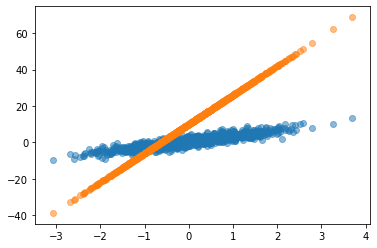

In [10]:
model = Model()

y_pred0 = model.predict(x)

plt.scatter(x, y, alpha=0.5)
plt.scatter(x, y_pred0, alpha=0.5)

In [11]:
def loss_fn(y_pred, y_true):
    return tf.reduce_mean(tf.square(y_true - y_pred))

In [12]:
@add_to_class(Model)
def fit_epoch(self, x, y_true, *, lr):

    with tf.GradientTape() as t:
        y_pred = self.predict(x)
        loss_val = loss_fn(y_pred, y_true)

    dw, db = t.gradient(loss_val, [self.w, self.b])

    self.w.assign_sub(lr * dw)
    self.b.assign_sub(lr * db)

    # !!: returns loss *before* parameters update
    return loss_val

In [13]:
@add_to_class(Model)
def fit(self, x, y_true, *, epochs=20, lr=0.1):

    history = {'w': [], 'b': [], 'loss': []}

    for epoch in range(epochs):
        history['w'].append(self.w.numpy())
        history['b'].append(self.b.numpy())

        loss_val = self.fit_epoch(x, y_true, lr=lr)

        loss_np = loss_val.numpy()
        history['loss'].append(loss_np)
        print(f"Epoch {epoch}: loss={loss_np:.4f}")
    
    history['w'].append(self.w.numpy())
    history['b'].append(self.b.numpy())
    loss_np = loss_fn(self.predict(x), y_true).numpy()
    history['loss'].append(loss_np)
    print(f"After fitting: loss={loss_np:.4f}")

    return history

In [14]:
EPOCHS = 20

In [15]:
history = model.fit(x, y, epochs=EPOCHS)

Epoch 0: loss=260.6725
Epoch 1: loss=167.9701
Epoch 2: loss=108.5255
Epoch 3: loss=70.4068
Epoch 4: loss=45.9630
Epoch 5: loss=30.2881
Epoch 6: loss=20.2363
Epoch 7: loss=13.7904
Epoch 8: loss=9.6568
Epoch 9: loss=7.0060
Epoch 10: loss=5.3060
Epoch 11: loss=4.2158
Epoch 12: loss=3.5167
Epoch 13: loss=3.0683
Epoch 14: loss=2.7808
Epoch 15: loss=2.5964
Epoch 16: loss=2.4781
Epoch 17: loss=2.4023
Epoch 18: loss=2.3536
Epoch 19: loss=2.3224
After fitting: loss=2.3024


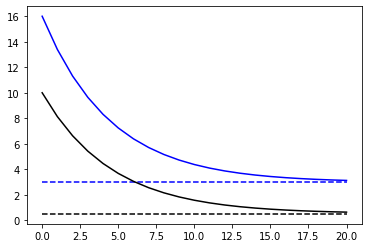

In [16]:
plt.plot(range(EPOCHS + 1), history['w'], 'b')
plt.plot(range(EPOCHS + 1), history['b'], 'k')
plt.hlines([TRUE_W, TRUE_B], 0, EPOCHS, ['b', 'k'], linestyles='--');

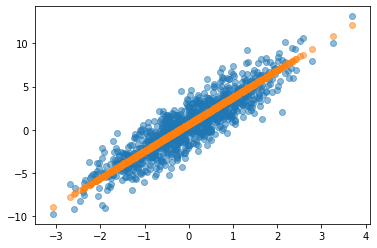

In [17]:
plt.scatter(x, y, label="true", alpha=0.5)
plt.scatter(x, model.predict(x), label="predicted", alpha=0.5);

# TF-Hub basics